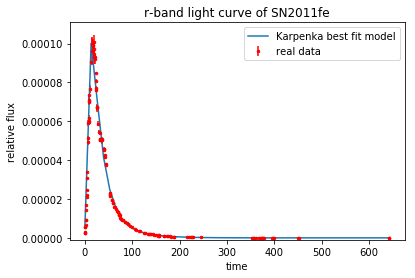

In [4]:
# import necessary libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# open and load the data 
source = open("SN2011fe.json")
json_data = json.load(source)

#limit JSON data to just photometry elements
photo_data = json_data['SN2011fe']['photometry'] 

#populate an array of just the R band elements
r_bands = []
for r in range(len(photo_data) - 1):
	if('band' in photo_data[r] and photo_data[r]['band'] == 'R'):
		r_bands.append(photo_data[r])

#create arrays to hold the time and corresponding magnitude and error
magnitudes = []
mag_errors = []
times = []

#populate the arrays
for r in r_bands:
	magnitudes.append(float(r['magnitude']))
	times.append(float(r['time']))
	mag_errors.append(float(r['e_magnitude']))

#convert magnitudes to flux
magnitudes = np.array(magnitudes)
flux = 10**(-2*magnitudes / 5) 

#convert magnitude errors to flux errors
mag_errors = np.array(mag_errors)
mag_max = magnitudes + mag_errors
flux_max = 10**(-2*mag_max / 5)
flux_errors = flux_max - flux


#define Kapernka function to model data
def FitFunc_(t, t_0, A, B, t_1, Tfall, Trise):
	first = A * (1 + (B * (t - t_1)*(t - t_1)))
	var = -(t - t_0)
	second = np.exp(var / Tfall)
	third = 1 + np.exp(var / Trise)
	return first * (second / third)
	
#shift times to start at 0; for curve_fit
times2 = np.array(times)
times2 = times2 - times2[0]


#store priors for the coefficients
priors = [50, 20, 20, 50, 50, 50]

#find the bestfit coefficients for the Kapenka function
fitCoeffs, Covars = curve_fit(FitFunc_, times2, flux, priors)


#Store the coefficients
bestfit_t = np.linspace(times2[0], times2[-1], 50)
bestfit_t_0 = fitCoeffs[0]
bestfit_A = fitCoeffs[1]
bestfit_B = fitCoeffs[2]
bestfit_t_1 = fitCoeffs[3]
bestfit_Tfall = fitCoeffs[4]
bestfit_Trise = fitCoeffs[5]


#Grab bestfit fluxes
bestfit_flux = FitFunc_(bestfit_t, bestfit_t_0, bestfit_A, bestfit_B, bestfit_t_1, bestfit_Tfall, bestfit_Trise)


#Plot data and bestfit line
plt.errorbar(times2, flux, yerr=flux_errors, color='red', label='real data', fmt = 'o', markersize = 2.5)
plt.plot(bestfit_t, bestfit_flux, label='Karpenka best fit model')
ax = plt.gca()
ax.set_ylim([-0.000001, np.amax(flux) + .00001])
plt.legend()
plt.title('r-band light curve of SN2011fe')
plt.xlabel('time')
plt.ylabel('relative flux')
plt.show()